# Light FM Approximate Nearest Neighbours (ANN) example

In this notebook, we'll be building a hybrid LightFM model on the example movielens dataset. 

We'll then store the item and user vectors, and build an ANN index over these for fast querying at scale. This technique can produce < 50ms response-times across millions of items.

We'll look at two popular ANN libraries, Annoy and NMSlib, and compare their performance.

Dependencies:
- Annoy - https://github.com/spotify/annoy
- NMSLIB - https://github.com/searchivarius/nmslib/tree/master/python_bindings

Firstly, let's import the data and build the Light FM model, as per the example in the docs:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import time
from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

/Users/lester/anaconda2/lib/python2.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [2]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

('test', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_features', <class 'scipy.sparse.csr.csr_matrix'>, (1682, 1682))
('train', <class 'scipy.sparse.coo.coo_matrix'>, (943, 1682))
('item_labels', <type 'numpy.ndarray'>, (1682,))
('item_feature_labels', <type 'numpy.ndarray'>, (1682,))


In [3]:
train = movielens['train']
test = movielens['test']

In [4]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='warp', no_components=64, item_alpha=0.001)

model.fit_partial(train, item_features=movielens['item_features'], epochs=20 )

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.73, test 0.10.
AUC: train 0.97, test 0.91.


We can get the item embeddings by simply multiplying the item features by the models item feature embeddings. Even better, LightFM has a performant built-in function to retrieve these embeddings givin a set of features.

In [5]:
_, item_embeddings = model.get_item_representations(movielens['item_features'])

Now let's make an annoy index for item to item querying:

In [7]:
from annoy import AnnoyIndex

factors = item_embeddings.shape[1] # Length of item vector that will be indexed
annoy_idx = AnnoyIndex(factors)  
for i in range(item_embeddings.shape[0]):
    v = item_embeddings[i]
    annoy_idx.add_item(i, v)

annoy_idx.build(10) # 10 trees
annoy_idx.save('movielens_item_Annoy_idx.ann')

True

And query the index for similar movies:

In [8]:
def nearest_movies_annoy(movie_id, index, n=10, print_output=True):
    nn = index.get_nns_by_item(movie_id, 10)
    if print_output:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn]
    if print_output:
        print("\n".join(titles))

In [11]:
nearest_movies_annoy(90, annoy_idx)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Beauty and the Beast (1991)
Fantasia (1940)
Aladdin (1992)
Jurassic Park (1993)
Sword in the Stone, The (1963)
Snow White and the Seven Dwarfs (1937)
Lion King, The (1994)
Princess Bride, The (1987)
Monty Python and the Holy Grail (1974)


Not bad, and it's very quick:

In [12]:
%%timeit
nearest_movies_annoy(90, annoy_idx, print_output=False)

The slowest run took 5.72 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 15.4 µs per loop


How about NMSlib?

In [13]:
import nmslib

# initialize a new nmslib index, using a HNSW index on Cosine Similarity
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [14]:
def nearest_movies_nms(movie_id, index, n=10, print_output=True):
    nn = index.knnQuery(item_embeddings[movie_id], k=10)
    if print_output == True:
        print('Closest to %s : \n' % movielens['item_labels'][movie_id])
    titles = [movielens['item_labels'][i] for i in nn[0]]
    if print_output == True:
        print("\n".join(titles))

In [15]:
nearest_movies_nms(90, nms_idx, n=10)

Closest to Nightmare Before Christmas, The (1993) : 

Nightmare Before Christmas, The (1993)
Beauty and the Beast (1991)
Fantasia (1940)
Aladdin (1992)
Star Trek: The Wrath of Khan (1982)
Heavy Metal (1981)
Jurassic Park (1993)
Aristocats, The (1970)
Blade Runner (1982)
Bram Stoker's Dracula (1992)


In [16]:
%%timeit 
nearest_movies_nms(90, nms_idx, n=10, print_output=False)

The slowest run took 4.93 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 26.7 µs per loop


<p>Again, good and maybe a little better, and also very fast. Now we'll do an example showing how we can do user recommendations using a neat trick outlined by the Xbox recomendations team: https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/XboxInnerProduct.pdf . Thanks to Ben Fredrickson https://github.com/benfred/ for bringing this one to light.</p>

<p>Basically we add a nomalizing factor to each item vector - making their distances equal with each other. Then when we query with a user vector, we add a 0 to the end, and the result is proportional to the inner producct of the user and item vectors. This is a sneaky way to do an aproximate maximum inner product search.

In [17]:
norms = np.linalg.norm(item_embeddings, axis=1)
max_norm = norms.max()
extra_dimension = np.sqrt(max_norm ** 2 - norms ** 2)
norm_data = np.append(item_embeddings, extra_dimension.reshape(norms.shape[0], 1), axis=1)

#First an Annoy index:

user_factors = norm_data.shape[1]
annoy_member_idx = AnnoyIndex(user_factors)  # Length of item vector that will be indexed

for i in range(norm_data.shape[0]):
    v = norm_data[i]
    annoy_member_idx.add_item(i, v)
    
annoy_member_idx.build(10)

# Now an NMS index

nms_member_idx = nmslib.init(method='hnsw', space='cosinesimil')
nms_member_idx.addDataPointBatch(norm_data)
nms_member_idx.createIndex(print_progress=True)

In [18]:
# Define our user vectors

_, user_embeddings = model.get_user_representations()

#### Now we can query as per the standard LightFM example

In [21]:
def sample_recommendation(user_ids, model, data, n_items=10, print_output=True):
    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        top_items = [data['item_labels'][i] for i in annoy_member_idx.get_nns_by_vector(np.append(user_embeddings[user_id], 0), 50)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [22]:
sample_recommendation([3,25,450], model, movielens, print_output=True)

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Cop Land (1997)
        Air Force One (1997)
        Contact (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Men in Black (1997)
        Toy Story (1995)
        Rock, The (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Hoodlum (1997)
        Excess Baggage (1997)
        G.I. Jane (1997)


#### Compare this to the original, non-ANN version here:

In [23]:
def sample_recommendation_original(model, data, user_ids, print_output=True):

    n_users, n_items = data['train'].shape

    for user_id in user_ids:
        known_positives = data['item_labels'][data['train'].tocsr()[user_id].indices]
        scores = model.predict(user_id, np.arange(n_items))
        top_items = data['item_labels'][np.argsort(-scores)]
        if print_output == True:
            print("User %s" % user_id)
            print("     Known positives:")

            for x in known_positives[:3]:
                print("        %s" % x)

            print("     Recommended:")

            for x in top_items[:3]:
                print("        %s" % x)

In [24]:
sample_recommendation_original(model, movielens, [3, 25, 450])

User 3
     Known positives:
        Seven (Se7en) (1995)
        Indiana Jones and the Last Crusade (1989)
        Contact (1997)
     Recommended:
        Contact (1997)
        Air Force One (1997)
        Cop Land (1997)
User 25
     Known positives:
        Toy Story (1995)
        Twelve Monkeys (1995)
        Dead Man Walking (1995)
     Recommended:
        Men in Black (1997)
        Toy Story (1995)
        Rock, The (1996)
User 450
     Known positives:
        Kolya (1996)
        Devil's Own, The (1997)
        Contact (1997)
     Recommended:
        Hoodlum (1997)
        G.I. Jane (1997)
        Cop Land (1997)


So pretty similar!

## But how fast are they, and do they scale?

Here are the two functions compared on a single prediction:

In [25]:
%%timeit
sample_recommendation_original(model, movielens, [3, 25, 450], print_output=False)

100 loops, best of 3: 4.56 ms per loop


In [26]:
%%timeit
sample_recommendation([3,25,450], model, movielens, print_output=False)

100 loops, best of 3: 2.88 ms per loop


So this is a bit faster, but at these volumes it probably doesn't justify the extra effort. Where these libraries provide value is against very large numbers of vectors. So let's see how the ANN libraries stack-up versus the Scikit-Learn pairwise distance function, which can also be used for (exact) nearest neighbour searches:

[Text(0,0.5,u'Time (ms)'), Text(0.5,0,u'Numer of vectors')]

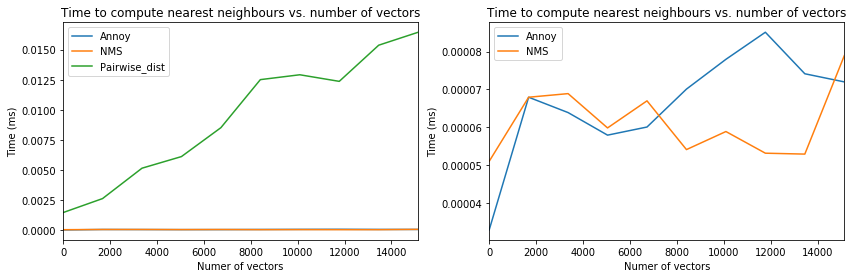

In [27]:
def time_nearest_neighbours_methods(item_embeddings):
    
    # Pairwise distances nearest neighbours
    start = time.time()
    distances = pairwise_distances(item_embeddings[0].reshape(1, -1), Y=item_embeddings)
    top_items = distances.argsort()[:10]
    end = time.time()
    pairwise_elapsed = end - start
    
    #NMS lib
    nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
    nms_idx.addDataPointBatch(item_embeddings)
    nms_idx.createIndex(print_progress=False)
    start = time.time()
    nms_idx.knnQuery(item_embeddings[0])[0]
    end = time.time()
    nms_elapsed = end - start
    
    #Annoy
    annoy_idx = AnnoyIndex(item_embeddings.shape[1])
    for i in range(item_embeddings.shape[0]):
        v = item_embeddings[i]
        annoy_idx.add_item(i, v)
    annoy_idx.build(10) # 10 trees
    
    start = time.time()
    annoy_idx.get_nns_by_vector(item_embeddings[0], 10)
    end = time.time()    
    annoy_elapsed = end - start
   
    return {'pairwise_elapsed': pairwise_elapsed, 'nms_elapsed': nms_elapsed, 'annoy_elapsed' : annoy_elapsed}

pairwise_timings = []
nms_timings = []
annoy_timings = []

for i in range (1, 100, 10):
    loop_item_embeddings = np.repeat(item_embeddings, i, axis=0)
    results = time_nearest_neighbours_methods(loop_item_embeddings)
    pairwise_timings.append(results['pairwise_elapsed'])
    nms_timings.append(results['nms_elapsed'])
    annoy_timings.append(results['annoy_elapsed'])
    
timings_df = pd.DataFrame({'Pairwise_dist':pairwise_timings, \
                           'NMS': nms_timings, \
                           'Annoy': annoy_timings}, \
                          index=np.arange(10)*item_embeddings.shape[0])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
ax = timings_df.plot(figsize=(14,4), title='Time to compute nearest neighbours vs. number of vectors', ax=axes[0])
ax.set(xlabel='Numer of vectors', ylabel='Time (ms)')
ax2 = timings_df.loc[:, 'Annoy':'NMS'].plot(figsize=(14,4), title='Time to compute nearest neighbours vs. number of vectors', ax=axes[1])
ax2.set(xlabel='Numer of vectors', ylabel='Time (ms)')

As you can see, both NMSLib and Annoy are a lot faster than the pairwise distance method with a larger numbers of vectors. In fact at these volumes, we can't really see any response-time increase at all as we add more vectors.

## So how does using an ANN library affect quality?

To get an idea, let's use our Annoy and NMS indexes to calculate predictions, and then evaluate their 'precision at K' versus the built-in predict method from LightFM.

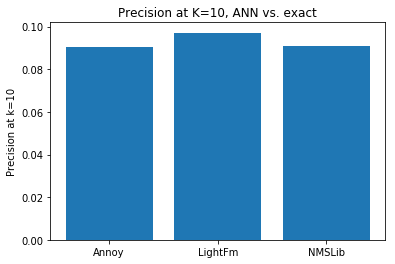

In [30]:
lightfm_pak = precision_at_k(model, test, k=10).mean()

def annoy_precision_at_k(user_ids, k=10):
    test_csr = test.tocsr()
    paks = []
    for user_id in user_ids:
        test_interactions = test_csr[user_id].indices
        if len(test_interactions) > 0:
            recommendations = annoy_member_idx.get_nns_by_vector(np.append(user_embeddings[user_id], 0), k)
            hits = len(set(test_interactions).intersection(recommendations))
            pak = hits / (len(test_interactions) * 1.0)
            paks.append(pak)
    return np.array(paks).mean()

annoy_pak = annoy_precision_at_k(np.arange(test.shape[0]))

def nms_precision_at_k(user_ids, k=10):
    test_csr = test.tocsr()
    paks = []
    for user_id in user_ids:
        test_interactions = test_csr[user_id].indices
        if len(test_interactions) > 0:
            recommendations = nms_member_idx.knnQuery(np.append(user_embeddings[user_id], 0), k=10)[0]
            hits = len(set(test_interactions).intersection(recommendations))
            pak = hits / (len(test_interactions) * 1.0)
            paks.append(pak)
    return np.array(paks).mean()

nms_pak = nms_precision_at_k(np.arange(test.shape[0]))

plt.bar(['LightFm', 'Annoy', 'NMSLib'], [lightfm_pak, annoy_pak, nms_pak])
plt.title('Precision at K=10, ANN vs. exact')
plt.ylabel('Precision at k=10')
plt.show()

## So, should you use one of these libraries?

On a smaller dataset, it's not worth the hassle and loss of accuracy for a small increase in speed. However, if you need to respond in < 100ms, then your vector set can only grow so large before you'll need to start thinking about one of these libraries. 

Annoy has the advantage of saving to a memory map, and so playing well with multiple processes in a production environment

NMSlib outperforms Annoy in terms of accuracy, but I also found that constructing indexes over a large dataset was slower. This becomes a problem if you have to rebuild your index frequently because of fast moving product catalogues etc. 